In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import optuna
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the UK DataFrame from EDA portion of analysis.
uk_rfm_df = pd.read_pickle('uk_rfm_df')

In [3]:
uk_rfm_df.head()

,CustomerID,Country,Recency,Frequency,Monetary,Frequency_log,Recency_log,Monetary_log,Cluster
0,12346.0,United Kingdom,326,1,77183.60,0.693147,5.789960,11.253955,3
333,12747.0,United Kingdom,3,11,4196.01,2.484907,1.386294,8.342128,2
334,12748.0,United Kingdom,1,206,31650.78,5.332719,0.693147,10.362550,2
335,12749.0,United Kingdom,4,5,4090.88,1.791759,1.609438,8.316760,2
380,12820.0,United Kingdom,4,4,942.34,1.609438,1.609438,6.849427,1


In [4]:
# Prepare feature matrix and target vector
X = uk_rfm_df[['Recency', 'Frequency', 'Monetary']]  # Features
y = uk_rfm_df['Cluster']  # Target (Cluster labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       442
           1       0.97      0.96      0.96       236
           2       0.98      0.97      0.98       187
           3       0.97      0.96      0.96       311

    accuracy                           0.97      1176
   macro avg       0.97      0.97      0.97      1176
weighted avg       0.97      0.97      0.97      1176



- **Overall Performance:** The model is performing quite well, with high precision, recall, and F1-scores across all four clusters. This implies that the Random Forest model has learned the underlying patterns of the data effectively and is able to predict customer cluster membership accurately.

- **Balanced Performance:** The metrics (precision, recall, and F1-score) are very similar across all clusters, indicating balanced performance. This suggests that the model does not significantly overfit or underfit any specific cluster and treats all the classes equally well.
- **Possible Improvements:** Although the scores are very high, there may still be some room for improvement by further hyperparameter tuning or feature engineering, especially to improve recall for clusters with slightly lower recall values (e.g., Cluster 1 and Cluster 3).

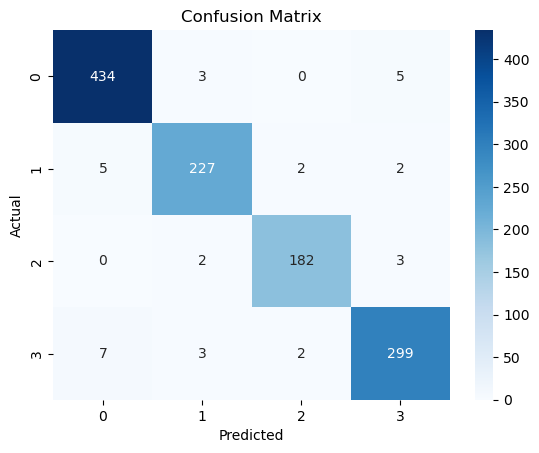

In [5]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [6]:
# Perform cross-validation to evalute model performance on different subsets of dataset.
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')

Cross-Validation Scores: [0.97321429 0.96556122 0.97576531 0.96296296 0.98212005]
Mean Cross-Validation Accuracy: 0.9719247660750124


In [7]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


In [8]:
# Update Random Forest Classifier with the best parameters
rf_model_updated = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    random_state=42
)

# Train the updated model
rf_model_updated.fit(X_train, y_train)

# Make predictions using the updated model
y_pred_updated = rf_model_updated.predict(X_test)

# Evaluate the updated model
print("Classification Report for Updated Model:")
print(classification_report(y_test, y_pred_updated))

Classification Report for Updated Model:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       442
           1       0.97      0.96      0.96       236
           2       0.98      0.97      0.98       187
           3       0.97      0.96      0.96       311

    accuracy                           0.97      1176
   macro avg       0.97      0.97      0.97      1176
weighted avg       0.97      0.97      0.97      1176



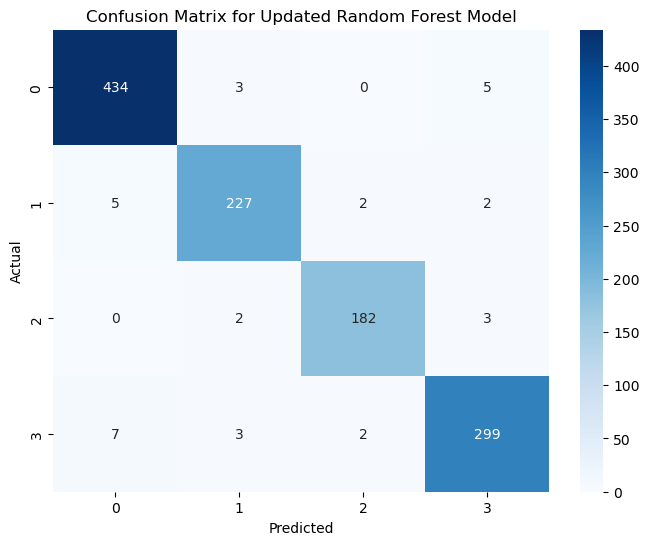

In [9]:
# Display Confusion Matrix for Updated Model
conf_matrix = confusion_matrix(y_test, y_pred_updated)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Updated Random Forest Model')
plt.show()

- The updated Random Forest model with tuned parameters showed no change using GridSearchCV, so I will use Bayesian Optimization to tune the model again.

In [10]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    
    # Create the Random Forest model with the given hyperparameters
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Perform cross-validation to evaluate the model
    score = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy').mean()
    
    return score

In [11]:
# Create a study to find the best hyperparameters using Bayesian Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can increase n_trials for better results

# Print the best hyperparameters found by Optuna
print("Best parameters:", study.best_params)

[I 2024-10-28 14:20:42,961] A new study created in memory with name: no-name-afb8c607-1158-47e3-8d56-8dc4e78f49c3
[I 2024-10-28 14:20:46,329] Trial 0 finished with value: 0.9671705689176073 and parameters: {'n_estimators': 376, 'max_depth': 26, 'min_samples_split': 10}. Best is trial 0 with value: 0.9671705689176073.
[I 2024-10-28 14:20:51,387] Trial 1 finished with value: 0.9711831731216678 and parameters: {'n_estimators': 557, 'max_depth': 15, 'min_samples_split': 4}. Best is trial 1 with value: 0.9711831731216678.
[I 2024-10-28 14:20:53,724] Trial 2 finished with value: 0.9671712336963025 and parameters: {'n_estimators': 260, 'max_depth': 10, 'min_samples_split': 5}. Best is trial 1 with value: 0.9711831731216678.
[I 2024-10-28 14:20:58,560] Trial 3 finished with value: 0.96935968516081 and parameters: {'n_estimators': 535, 'max_depth': 29, 'min_samples_split': 5}. Best is trial 1 with value: 0.9711831731216678.
[I 2024-10-28 14:21:04,450] Trial 4 finished with value: 0.969360349939

Best parameters: {'n_estimators': 162, 'max_depth': 30, 'min_samples_split': 3}


In [12]:
# Train the Random Forest model with the best parameters found
best_params = study.best_params
rf_model_optimized = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

rf_model_optimized.fit(X_train, y_train)

# Make predictions using the optimized model
y_pred_optimized = rf_model_optimized.predict(X_test)

# Evaluate the model
print("Classification Report for Optimized Model:")
print(classification_report(y_test, y_pred_optimized))


Classification Report for Optimized Model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       442
           1       0.95      0.97      0.96       236
           2       0.98      0.97      0.97       187
           3       0.97      0.95      0.96       311

    accuracy                           0.97      1176
   macro avg       0.97      0.97      0.97      1176
weighted avg       0.97      0.97      0.97      1176



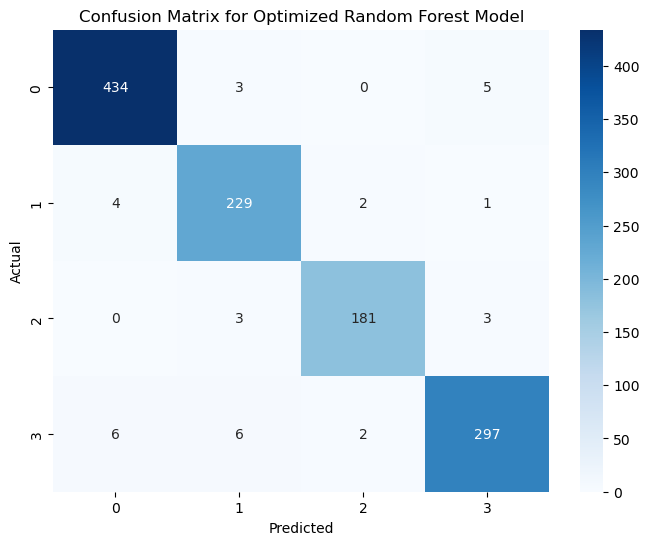

In [13]:
# Generate confusion matrix
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_optimized, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Optimized Random Forest Model')
plt.show()

- Given the marginal gains and potential for overfitting, it might be beneficial to try different models (e.g., Gradient Boosting or XGBoost) that might perform better for this data. 

In [14]:
# Train an XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("Classification Report for XGBoost Model:")
print(classification_report(y_test, y_pred_xgb))

Classification Report for XGBoost Model:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       442
           1       0.97      0.96      0.97       236
           2       0.98      0.99      0.99       187
           3       0.97      0.96      0.96       311

    accuracy                           0.97      1176
   macro avg       0.97      0.97      0.97      1176
weighted avg       0.97      0.97      0.97      1176



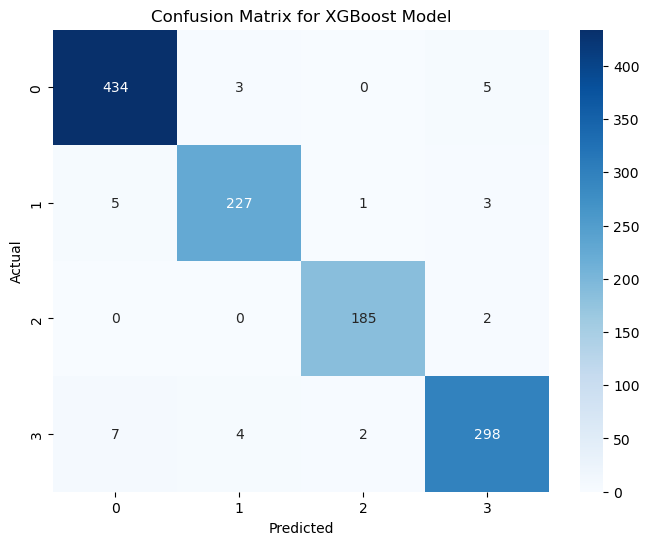

In [15]:
# Generate confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

- XGBoost appears to perform slightly better, particularly in reducing the misclassification rates and improving recall across clusters. Given the complexity and nature of the data, XGBoost’s boosted decision tree approach helps in handling the finer distinctions between clusters, which has led to marginally better performance. I will try to tune the XGBoost model further to see if additional gains can be made.

In [16]:
# Define individual models
xgb_model = XGBClassifier(random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    random_state=42
)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    voting='soft'  # 'soft' voting for average probability
)

In [17]:
# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate the ensemble model
print("Classification Report for Ensemble Model:")
print(classification_report(y_test, y_pred_ensemble))

Classification Report for Ensemble Model:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       442
           1       0.97      0.96      0.96       236
           2       0.98      0.98      0.98       187
           3       0.97      0.96      0.97       311

    accuracy                           0.98      1176
   macro avg       0.97      0.97      0.97      1176
weighted avg       0.98      0.98      0.98      1176



/Applications/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


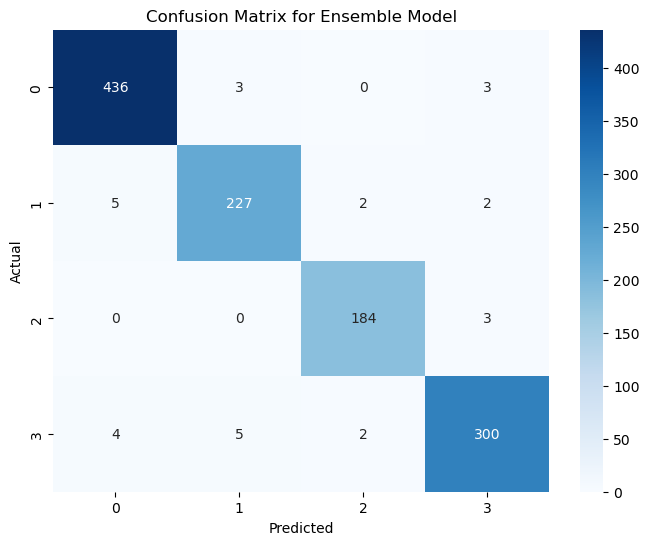

In [18]:
# Generate confusion matrix for the ensemble model
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Ensemble Model')
plt.show()

- The ensemble model has a high accuracy of 98%.
- It achieves a balanced performance across all metrics (precision, recall, and f1-score) for each cluster.
- The confusion matrix shows fewer misclassifications compared to other models, particularly in clusters where the recall values were previously lower. This indicates that combining different models helps to reduce overfitting and leverages the strengths of multiple classifiers.